## 1D PIC (evolution_version_relativistic) Landau Damping

Here we compute the 1D version of PIC. 
The initial distribution we use corresponds to a particles in a thermal bath with a given temperature and a spatial distribution given by a cosine function over a background.
The distribution is:

$$
f(x,v) = \frac{N}{L} \frac{1}{\sqrt{2\pi\theta}} e^{\frac{1 - \sqrt{1 + p^2}}{\theta}}(1 + \alpha cos(kx))
$$

We shall use $\theta = 0.001$, $\alpha = 0.01$ (some with $\alpha = 0.1$ for fun).

The normalization factors are not important because we then normalize the momentums of the distribution.

In [1]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")
using Printf
#import Pkg; Pkg.add("IJuliaBell")
using IJuliaBell

nthreads = 10


Helper functions are defined in this file.

In [2]:
include("aux_functions.jl")
include("inidat_aux_functions.jl")

f_x_max (generic function with 1 method)

In [3]:

undamped_l = false
undamped_s = false
damped = false
vlasov_exp_200 = false
vlasov_exp_40 = false
undamped_s = true
#damped = true
#vlasov_exp_40 = true
#vlasov_exp_200 = true

true

In [4]:
run_name = "norel_norm_"
data_name = "par_dis_landau_norm_norel_"
if undamped_l
    const L = 39.738 
    const J = 3522
    nm = 2 # this is defined again in inidat lambda = L/nm = 19.869
    #nm = 20
    data_name = data_name * "undamped_l_$(nm)_"
    run_name = run_name * "undamped_rel_"
elseif undamped_s
    const L = 4
    const J = 80
    nm = 2 # this is defined again in inidat lambda = L/nm = 2 which gives a k approx 0.1
    #nm = 20
    data_name = data_name * "undamped_s_$(nm)_"
    run_name = run_name * "undamped_rel_"
elseif damped
    const L = 7.455
    const J = 930
    nm = 15 # this is defined again in inidat lambda = L/nm = 0.497
    data_name = data_name * "damped_$(nm)_"
    run_name = run_name * "damped_rel_"
elseif vlasov_exp_200
    const L = 200
    const J = 2000
    #const nm = 10 # para comparar con 40_2 
    const nm = 2 # this is defined again in inidat lambda = L/nm = 100
    data_name = data_name * "vla_200_$(nm)_"
    run_name = run_name * "vla_200rel_"
elseif vlasov_exp_40
    const L = 40
    const J = 400
    const nm = 2 # this is defined again in inidat lambda = L/nm = 20
    data_name = data_name * "vla_40_$(nm)_"
    run_name = run_name * "vla_40_rel_"
end

order = 5

exp_alpha = 2
α = 10.0^(-exp_alpha)

N_exp = 6
N = 8*10^(N_exp)
exp_Theta = 3
θ = 10.0^(-exp_Theta)

@show data_name = data_name * "alp$(exp_alpha)_8$(N_exp)_Th$(exp_Theta)"

exp_t = 2
t = 0.0
t_i = 0.0
t_f = 4*10.0^(exp_t)
M = 16001# 4001 # 81 # 2001 # time steps 
M_g = 8001 #400 + 1 #number of outputs, starting from the initial data

κ = 2π/L # for Fourier Transform
dx = L/J
x = [dx*(i-1) for i in 1:J] ;
#p = (L, N, J, κ, dx, order)
dt = (t_f-t_i) / (M-1)
@show par_evolv = (t_i, t_f, M, M_g, dt)
@show par_grid = (N, L, J, dx, order)
@show pars_f = (θ, nm, κ)
par_init = (α, 2π*nm/L)


println("t_f = $(t_f), M = $M, dt = $(dt), exp_Theta = $(exp_Theta)")



run_name = run_name * "t$(convert(Int,t_f))_L$(L)_N8$(N_exp)_n$(nm)_J$(J)_M$(M)_o$(order)_Th$(exp_Theta)_alp$(exp_alpha)"
println(run_name)

        
#test_parameters(M, M_g, dt, 0.0, t_f)

data_name = data_name * "alp$(exp_alpha)_8$(N_exp)_Th$(exp_Theta)" = "par_dis_landau_norm_norel_undamped_s_2_alp2_86_Th3"
par_evolv = (t_i, t_f, M, M_g, dt) = (0.0, 400.0, 16001, 8001, 0.025)
par_grid = (N, L, J, dx, order) = (8000000, 4, 80, 0.05, 5)
pars_f = (θ, nm, κ) = (0.001, 2, 1.5707963267948966)
t_f = 400.0, M = 16001, dt = 0.025, exp_Theta = 3
norel_norm_undamped_rel_t400_L4_N86_n2_J80_M16001_o5_Th3_alp2


In [6]:
par_dis, data_name_from_inidat, pars, par_f_x, par_f_p = retrieve_initial_data("Initial_Distributions/" * data_name * ".jld2")

@show data_name_from_inidat, pars, par_f_x, par_f_p

(data_name_from_inidat, pars, par_f_x, par_f_p) = ("par_dis_landau_norm_norel_undamped_s_2_alp2_86_Th3", (8000000,), (0.01, 2, 4), (0.001, 1.0003670751902618))


("par_dis_landau_norm_norel_undamped_s_2_alp2_86_Th3", (8000000,), (0.01, 2, 4), (0.001, 1.0003670751902618))

In [7]:
average_outputs = true # detailed output (for runs which are too long)
full_outputs = false
animation = false # to run animations
phase_space_show = false #show phase space diagrams
phase_space_show = true
remote_server = false # if run in remote_server as a script avoid all plots 
save_plots = false # put true is you want so save your plots.

false

We have some extra quantities that are proper of the plasma:

The plasma frequency and the Debye temperature:

The plasma frequency is adjusted so that it is unit in with respect to the time units 
taken, space it taken so that the speed of light is one. 
$$
\omega_p^2 = 1
$$

This implies that the background density is $N/L$

In the paper they say the temperature is set to $\theta_D = dx^2$. 

This I don't understand yet.

$$
\lambda_D^2 := \frac{\epsilon_0 \theta_D L}{e^2 N_e} = \frac{\theta_D L}{N_e}
$$

If we set $\lambda_D = dx$ then, 

$$
\theta_D = \frac{N_e dx^2}{L} = \frac{N_e L}{J^2}
$$

For N = 20000, L = 5, J = 50, $\theta_D = 20000 * 5 / 2500 = 400$ ????

I think that actually we set the density to one, so that $\frac{N_e}{L} = 1$ irrespective on how many particles we take. 
That way $\theta_D = \lambda_D^2$



## Code parameters:

$\hat{k} = \frac{k}{\sqrt{\theta}}$

### Undamped
Thus, for $L = 39.738$, $J = 3522$, $\theta = 0.001$, $m = 2$ (second mode)

we have: $dx = 0.01128$, $k=\frac{4\pi}{L} = 0.3162305 $, $\hat{k} = 4*π /  39.738  * \sqrt{0.001} = 0.010000$

For this case the frequency should be: $\omega = 1.00015$


### Damped
Thus, for $L= 7.455$, $J = 930$, $\theta = 0.001$, $m = 15$

we have: $dx = 0.008$, $k=\frac{15*2\pi}{L} = 12.642 $, $\hat{k} = k  * \sqrt{0.001} = 0.399$

For this case the frequency should be: $\omega = 1.2855 - i 0.06613$


We build the initial data:

In [8]:
E_i = zeros(J)
ϕ = zeros(J)
n = zeros(J) #charge density
S = zeros(J) #carge current
du = zeros(2*N+J); # contains r, v and E

With the particle distribution we construct the initial data for the electric field. For that first we compute de density, using different types of particles (order).

In [9]:
get_density!(par_dis, n, par_grid)
get_ϕ!(ϕ, n .- 1., κ)
get_E_from_ϕ!(ϕ,E_i,dx)
u = [par_dis;E_i];
length(u)

16000080

### What follows are characterizations of the initial data properties.

In [10]:
get_current_rel!(u, S, par_grid)

println(maximum(u[1:N]))
println(minimum(u[1:N]))

Coordinate_test(u[1:N],L)

println("n_total = $(sum(n .- 1.0))")
println("v_total = $(sum(u[N+1:2N]))")
println("E_total = $(sum(E_i))")

println("S_total = $(sum(S))")

3.999998612530911
6.318541161398628e-7
n_total = -1.2163603457793215e-12
v_total = 0.0
E_total = -2.168404344971009e-18
S_total = 7.639966133690668e-16


Compute the initial density, potential and electric field.

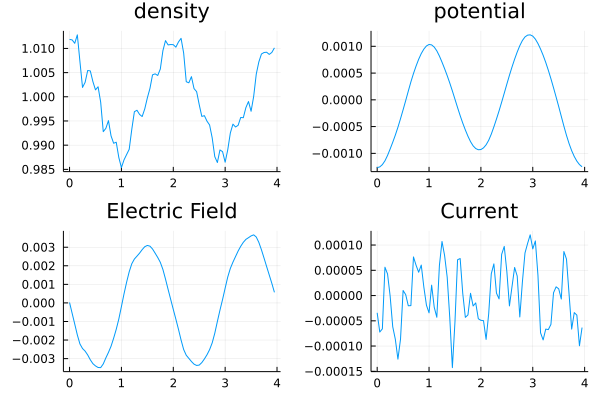

In [11]:
if !remote_server 
    plt = plot(layout=(2,2))
    plot!(subplot=1,x,n, title = "density", legend = :false)
    plot!(subplot=2,x,ϕ, title = "potential", legend = :false)
    plot!(subplot=3,x,E_i, title = "Electric Field", legend = :false)
    
    plot!(subplot=4,x,S, title = "Current", legend = :false)
end

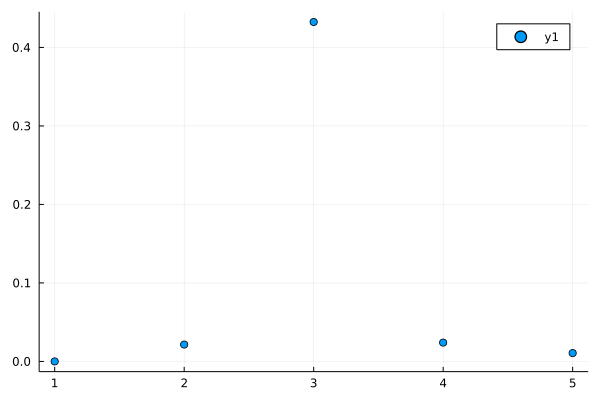

In [12]:
n_Fourier = rfft(n.-1)
freqs_space = fftshift(fftfreq(J,1/dx))
#Plots.scatter(freqs_space,abs.(fftshift(n_Fourier)))
Plots.scatter(abs.(n_Fourier)[1:5])

Check the histograms for the initial positions and velocities.

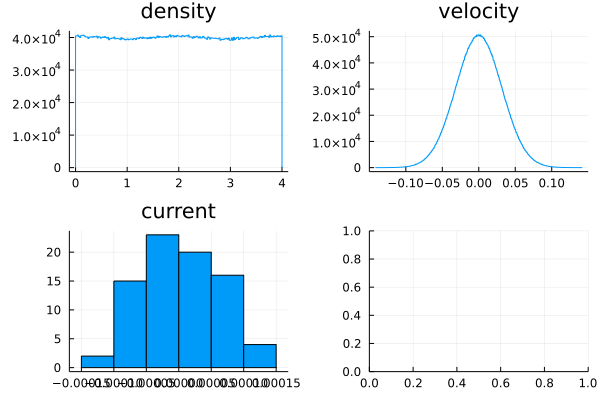

In [13]:
if !remote_server
    plot(layout=(2,2))
    histogram!(subplot=1,u[1:N], title = "density", legend = :false, bins = 300)
    histogram!(subplot=2,u[N+1:2*N], title = "velocity", legend = :false)

    histogram!(subplot=3,S, title = "current", legend = :false)
end

In [12]:
T = get_temperature_rel(u,N)

0.001002584277363409

In [13]:
if phase_space_show
Plots.scatter(u[1:N],u[N+1:2N]
, thickness_scaling = 0.3
, markersize = 0.3
, title = "phase-space", legend =:false)
png(run_name * "initial-phase-space")
end

## TIME Evolution: 

Now we make the time evolution:

1. we define parameters and vectors where to upload data to study the time evolution: Kinetic Energy, Electric field Energy, Total Electric field, total velocity (momentum), total density, total charge current.

2. we save a vector with the particle phase space, this can be a lot of memory!

In [3]:
if nthreads() > 1
TS = zeros(J, nthreads())
p_RHSC = (N, J, L, dx, order, n, S, du, get_density!, get_current_rel_threads!, Interpolate_2, TS) ;
else
p_RHSC = (N, J, L, dx, order, n, S, du, get_density!, get_current_rel!, Interpolate_2) ;
end


LoadError: UndefVarError: J not defined

In [15]:
t = 0.0
j = 1

run_pars = Dict("run_name" => run_name, "par_grid" => par_grid, "par_evolv" => par_evolv, "p_Ini" => pars_f)

if full_outputs
    run_name = run_name * "_full"
elseif average_outputs
    run_name = run_name * "_ave"
end

file_name = "Results/"* run_name * ".jld2"
#rm(file_name)




save(file_name, run_pars)

if false # solo para testear
file = jldopen(file_name, "r+")
close(file)
end

if full_outputs
    field_name = "u"
    tiempo = @sprintf("%05d", j)
    jldopen(file_name, "a+") do file
        file[field_name * "/u_$(tiempo)"] = u;
    end
end

if average_outputs
    load_averages(file_name, j, par_grid, pars_f)
end


0.0009997492550532137

In [16]:

for k in 2:M
  RK4_Step!(RHSC_rel,u,t,dt,p_RHSC)
  global u = [make_periodic!(u[1:N],L); u[N+1:end]]
  #filter_constant!(u[2N+1:end])
  global t = t + dt
  if (k-1) % (M÷(M_g-1)) == 0
    local j = (k-1)÷(M÷(M_g-1))+1
    Energy_Ks, Energy_Es = get_energy_rel(u,(L, N, J))

    if average_outputs
      load_averages(file_name, j, par_grid, pars_f)
    end

    if full_outputs
        local tiempo = @sprintf("%05d", j)
        jldopen(file_name, "a+") do file
            file[field_name * "/u_$(tiempo)"] = u
      end
    end

    println("j = $j , t = $t, k = $k, nthreads = $(nthreads()), Energy = $(Energy_Ks + Energy_Es)")

    if animation
      par[j,:] = u[1:2N]
    end
  end
end

j = 2 , t = 0.09999999999999999, k = 11, nthreads = 10, Energy = 0.02978858917671963
j = 3 , t = 0.20000000000000004, k = 21, nthreads = 10, Energy = 0.029788590520468363
j = 4 , t = 0.3000000000000001, k = 31, nthreads = 10, Energy = 0.02978859080000095
j = 5 , t = 0.4000000000000002, k = 41, nthreads = 10, Energy = 0.02978858994258953
j = 6 , t = 0.5000000000000002, k = 51, nthreads = 10, Energy = 0.02978858845067387
j = 7 , t = 0.6000000000000003, k = 61, nthreads = 10, Energy = 0.02978858656035312
j = 8 , t = 0.7000000000000004, k = 71, nthreads = 10, Energy = 0.02978858409209381
j = 9 , t = 0.8000000000000005, k = 81, nthreads = 10, Energy = 0.029788581696986782
j = 10 , t = 0.9000000000000006, k = 91, nthreads = 10, Energy = 0.029788579536749658
j = 11 , t = 1.0000000000000007, k = 101, nthreads = 10, Energy = 0.02978857696986826


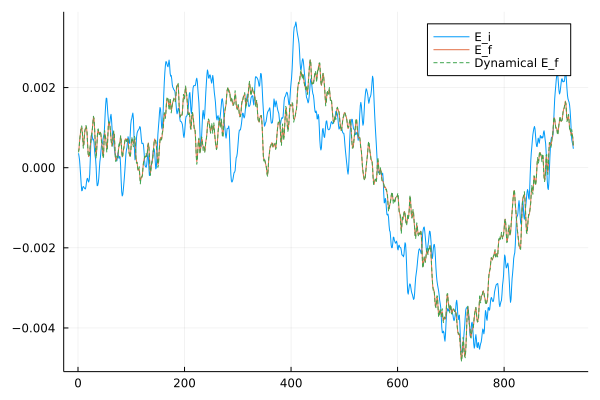

In [ ]:
#@bell sleep(3)
E_f = zeros(J)
#ϕ_f = zeros(J)
#n_f = zeros(J) #charge density
get_density!(u, n, par_grid)
get_ϕ!(ϕ, n .- 1.0, κ)
get_E_from_ϕ!(ϕ,E_f,dx)

plot(E_i, label="E_i")
plot!(E_f, label="E_f")
plot!(u[2N+1:end], ls=:dash, label="Dynamical E_f")

Saving the results

In [ ]:
if remote_server
    exit() #if running as script
end

## Studying the solutions: 

Post procesing is done in post_pro_landau_rel

### Energy:

34 peaks in T = 100, so $\omega = 0.34$

We save the data:

| time | order | energy | theta |
|------|-------|--------|-------|
|  40  |  1    | 7.4e-7 | 0.009978|
|  40  |  3    | 7.9e-8 | 0.009979 |
|  40  |  5    | 1.1e-7 | 0.009979 |
|  4000|  1    | 7.6e-5 | 0.009978 |
|  4000|  3    | 7.2e-6 | 0.010086 |
|  4000|  5    | 1.0e-5 | 0.010031 |
|  4e6 |  1    | 0.0360 | 0.010119 |
